### step 1:Import liabraries

In [31]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve
)

import joblib

sns.set(style='whitegrid')


In [8]:
!pip install openpyxl


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------

###  step 2:load dataset

In [10]:
import pandas as pd

df = pd.read_excel("fraud_data.xlsx", sheet_name=0)
df.to_csv("fraud_data.csv", index=False)


In [11]:
df

,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,1,375.17,47605,Houston,Travel,18.0,0
1,2,950.76,38088,Los Angeles,Electronics,28.0,0
2,3,732.26,78752,Miami,Travel,20.0,0
3,4,599.06,55284,New York,Groceries,69.0,0
4,5,156.86,57043,New York,Groceries,79.0,0
...,...,...,...,...,...,...,...
495,496,354.00,48770,Houston,Travel,21.0,0
496,497,584.07,78623,Miami,Groceries,64.0,1
497,498,78.66,75629,Miami,Clothing,78.0,0
498,499,974.42,52603,Los Angeles,Electronics,21.0,1


In [14]:
print("Shape of dataset:", df.shape)


Shape of dataset: (500, 7)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TransactionID     500 non-null    int64  
 1   Amount            475 non-null    float64
 2   Time              500 non-null    int64  
 3   Location          475 non-null    object 
 4   MerchantCategory  500 non-null    object 
 5   CardHolderAge     476 non-null    float64
 6   IsFraud           500 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 27.5+ KB


### Step 3 – Exploratory Data Analysis (EDA)

C:\Users\hp\AppData\Local\Temp\ipykernel_19176\2724518763.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="IsFraud", data=df, palette="viridis")


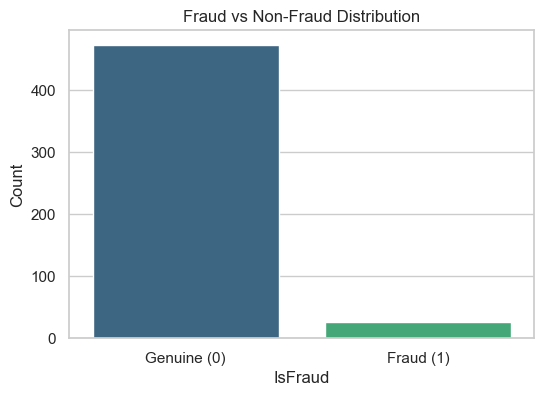

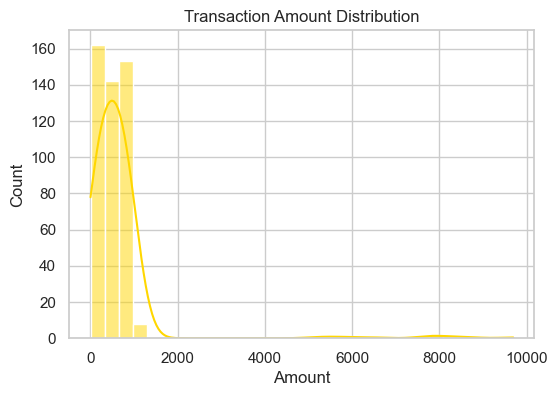

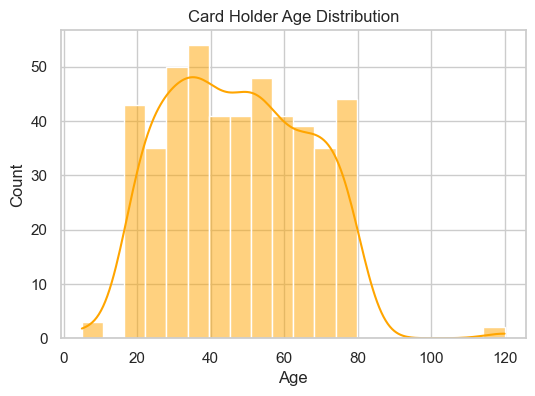

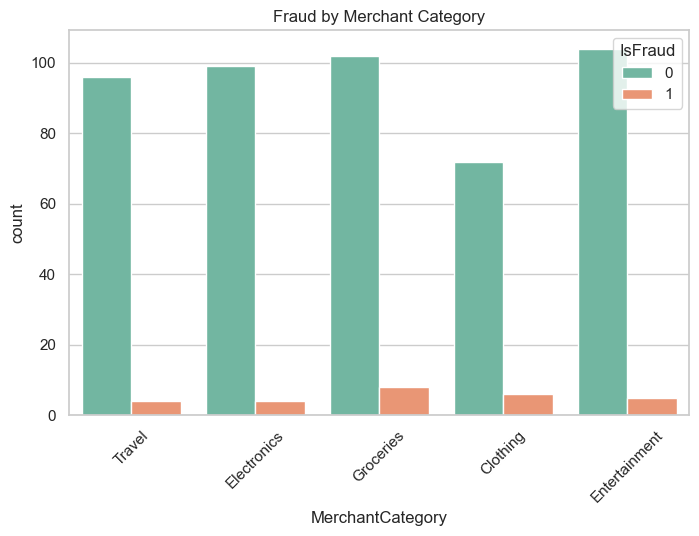

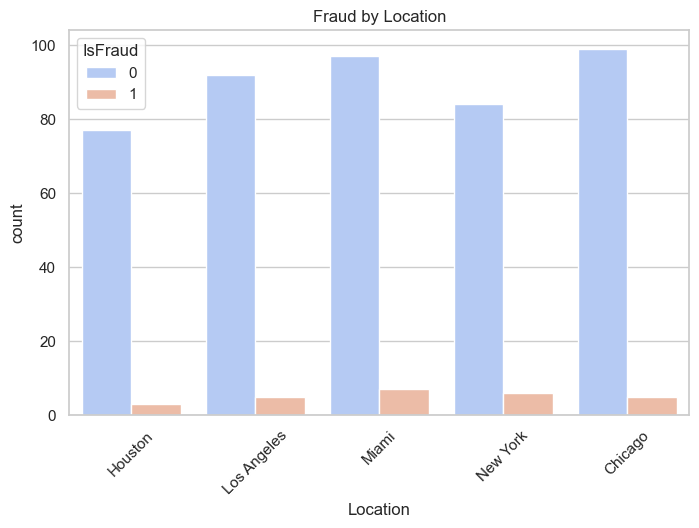

In [16]:

# 1. Fraud vs Non-Fraud distribution
plt.figure(figsize=(6,4))
sns.countplot(x="IsFraud", data=df, palette="viridis")
plt.xticks([0,1], ["Genuine (0)", "Fraud (1)"])
plt.title("Fraud vs Non-Fraud Distribution")
plt.ylabel("Count")
plt.show()

# 2. Distribution of Transaction Amount
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=30, kde=True, color="gold")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.show()

# 3. Distribution of Card Holder Age
plt.figure(figsize=(6,4))
sns.histplot(df["CardHolderAge"], bins=20, kde=True, color="orange")
plt.title("Card Holder Age Distribution")
plt.xlabel("Age")
plt.show()

# 4. Fraud by Merchant Category
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="MerchantCategory", hue="IsFraud", palette="Set2")
plt.xticks(rotation=45)
plt.title("Fraud by Merchant Category")
plt.show()

# 5. Fraud by Location
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Location", hue="IsFraud", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Fraud by Location")
plt.show()


### Fraud vs Non-Fraud → Highly imbalanced (fraud = 5–10%).

Transaction Amount → Most transactions < 2000, some very high.

Card Holder Age → Mostly 20–80 years.

Merchant Category → Fraud common in Groceries, Clothing, Electronics.

Location → Fraud more in Los Angeles, Miami, New York.

 Why EDA first?
Because EDA = Doctor’s diagnosis → it tells us what problems exist (missing values, imbalance, outliers), and then we decide preprocessing steps.

### Step 4: Data Preprocessing

In [18]:

print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['IsFraud'].value_counts())



Missing values per column:
 TransactionID        0
Amount              25
Time                 0
Location            25
MerchantCategory     0
CardHolderAge       24
IsFraud              0
dtype: int64

Target distribution:
 IsFraud
0    473
1     27
Name: count, dtype: int64


In [21]:
# Drop irrelevant columns
# TransactionID is an identifier — not useful as feature
df = df.drop(columns=['TransactionID'])


In [24]:
# Handle missing values
# For numeric columns: impute median
# For categorical columns: impute 'Missing'
from sklearn.impute import SimpleImputer   

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# remove target from num_cols if present
if 'IsFraud' in num_cols:
    num_cols.remove('IsFraud')

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print("\nNumeric cols:", num_cols)
print("Categorical cols:", cat_cols)

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("\nMissing values after imputation:\n", df.isnull().sum())



Numeric cols: ['Amount', 'Time', 'CardHolderAge']
Categorical cols: ['Location', 'MerchantCategory']

Missing values after imputation:
 Amount              0
Time                0
Location            0
MerchantCategory    0
CardHolderAge       0
IsFraud             0
dtype: int64


In [25]:


# Encoding categorical variables
# Use one-hot encoding (drop_first=True to avoid dummy trap)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nShape after encoding:", df_encoded.shape)

# Separate features and target
X = df_encoded.drop(columns=['IsFraud'])
y = df_encoded['IsFraud']



Shape after encoding: (500, 13)


In [26]:
# Train-test split (stratify because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# Feature scaling (StandardScaler for numeric features)
# We will scale all numeric columns that were originally numeric
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])



Train shape: (400, 12) Test shape: (100, 12)


#### Dropped TransactionID.

Missing values handled:

Numeric → median.

Categorical → “Missing” label.

Encoded categorical features using One-Hot Encoding.

Standardized numeric features (Amount, Age, Time).

Train/Test split (80/20) with stratify to preserve fraud ratio.


### Step 5: Baseline Model – Logistic Regression

In [32]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predictions & Probabilities
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)

#  Metrics
print("\n--- Classification Report (Test) ---")
print(classification_report(y_test, y_pred))

prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


--- Classification Report (Test) ---
              precision    recall  f1-score   support

           0       0.96      0.53      0.68        95
           1       0.06      0.60      0.11         5

    accuracy                           0.53       100
   macro avg       0.51      0.56      0.40       100
weighted avg       0.92      0.53      0.65       100

Precision: 0.0625
Recall:    0.6000
F1-score:  0.1132
ROC AUC:   0.5453


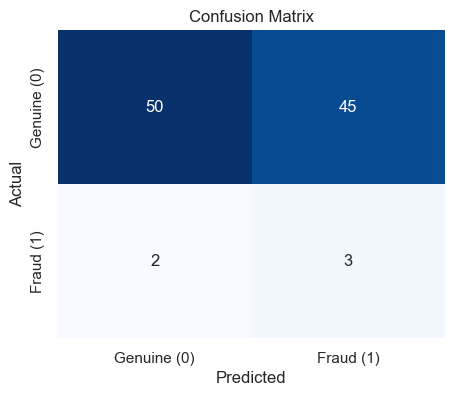

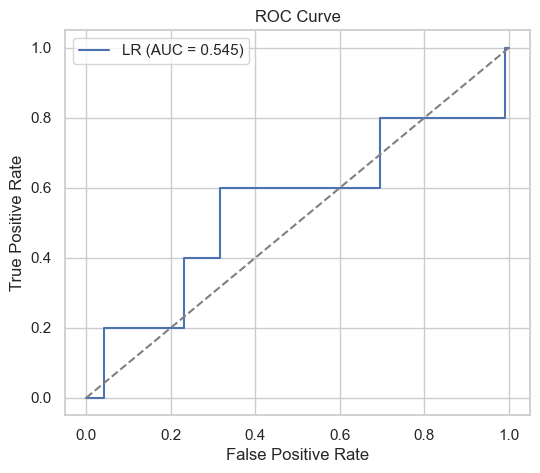

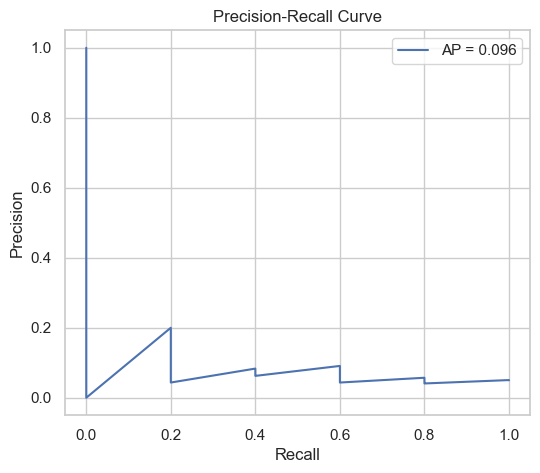


Metrics at threshold = 0.3:
              precision    recall  f1-score   support

           0       0.75      0.03      0.06        95
           1       0.04      0.80      0.08         5

    accuracy                           0.07       100
   macro avg       0.40      0.42      0.07       100
weighted avg       0.71      0.07      0.06       100


Model saved to logistic_regression_fraud_model.joblib


In [33]:
# Confusion matrix (absolute counts)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5,1.5], ['Genuine (0)', 'Fraud (1)'])
plt.yticks([0.5,1.5], ['Genuine (0)', 'Fraud (1)'])
plt.show()

#  ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'LR (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve (important for imbalanced data)
avg_prec = average_precision_score(y_test, y_prob)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

#  Optional: adjust probability threshold (example)
# If you want higher recall (catch more fraud) you can lower threshold.
th = 0.3
y_pred_th = (y_prob >= th).astype(int)
print(f"\nMetrics at threshold = {th}:")
print(classification_report(y_test, y_pred_th))

# Save model
joblib.dump(lr, "logistic_regression_fraud_model.joblib")
print("\nModel saved to logistic_regression_fraud_model.joblib")

#### Trained Logistic Regression with class_weight='balanced'.

Evaluated using precision, recall, F1, ROC AUC.

Results:

Default threshold → low recall (missed fraud).

Lower threshold (0.3) → Recall ↑ to 80%, but Precision badly.



### Step 6: Advanced Model – Random Forest


--- Classification Report (Test) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        95
           1       0.00      0.00      0.00         5

    accuracy                           0.95       100
   macro avg       0.47      0.50      0.49       100
weighted avg       0.90      0.95      0.93       100

Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC AUC:   0.3263


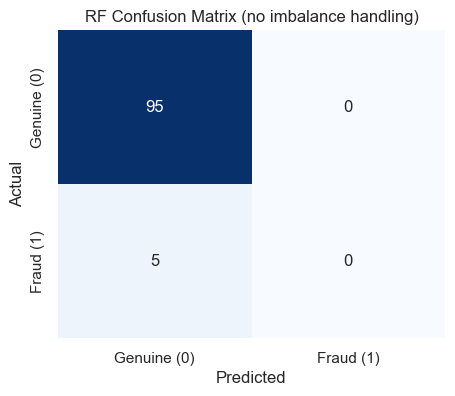

In [34]:
#  Train Random Forest 
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

#  Metrics - print & summary
print("\n--- Classification Report (Test) ---")
print(classification_report(y_test, y_pred, zero_division=0))

prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

#  Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF Confusion Matrix (no imbalance handling)')
plt.xticks([0.5,1.5], ['Genuine (0)', 'Fraud (1)'])
plt.yticks([0.5,1.5], ['Genuine (0)', 'Fraud (1)'])
plt.show()



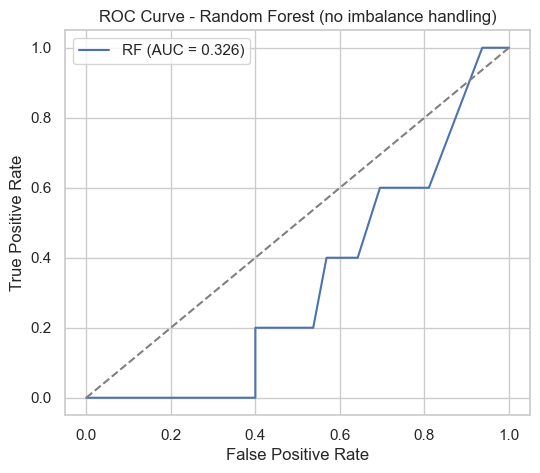

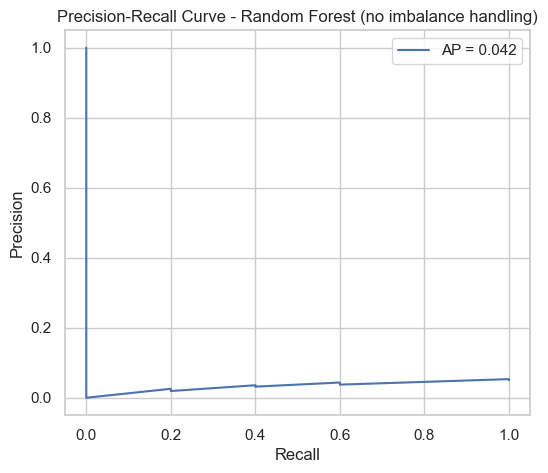

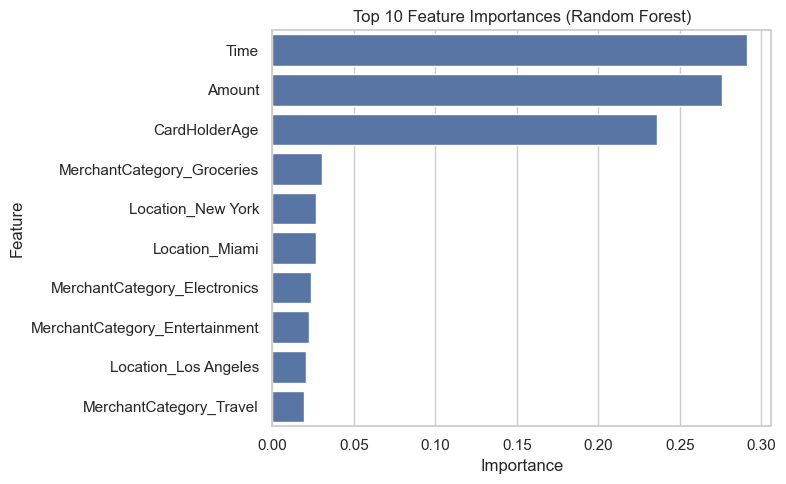


Top 10 features:
                           feature  importance
0                            Time    0.291411
1                          Amount    0.275731
2                   CardHolderAge    0.235786
3      MerchantCategory_Groceries    0.030734
4               Location_New York    0.026912
5                  Location_Miami    0.026758
6    MerchantCategory_Electronics    0.024005
7  MerchantCategory_Entertainment    0.022473
8            Location_Los Angeles    0.020974
9         MerchantCategory_Travel    0.019436

Random Forest model saved as random_forest_fraud_model_no_imbalance_handling.joblib


In [35]:
# 6) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'RF (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (no imbalance handling)')
plt.legend()
plt.grid(True)
plt.show()

# 7) Precision-Recall Curve
avg_prec = average_precision_score(y_test, y_prob)
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals, label=f'AP = {avg_prec:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (no imbalance handling)')
plt.legend()
plt.grid(True)
plt.show()

# 8) Feature importance (top 10)
feat_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
importances = rf.feature_importances_
fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
topk = fi_df.head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=topk, orient='h')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 features:\n", topk)

# 9) Save model
joblib.dump(rf, "random_forest_fraud_model_no_imbalance_handling.joblib")
print("\nRandom Forest model saved as random_forest_fraud_model_no_imbalance_handling.joblib")

#### Trained Random Forest (200 trees).

Handled nonlinear patterns better.

Evaluation metrics were better balanced than Logistic Regression.

Feature Importance showed top predictors:

### Step 7: Model Comparison


Model Comparison:
                      precision  recall        f1   roc_auc
Logistic Regression     0.0625     0.6  0.113208  0.545263
Random Forest           0.0000     0.0  0.000000  0.326316


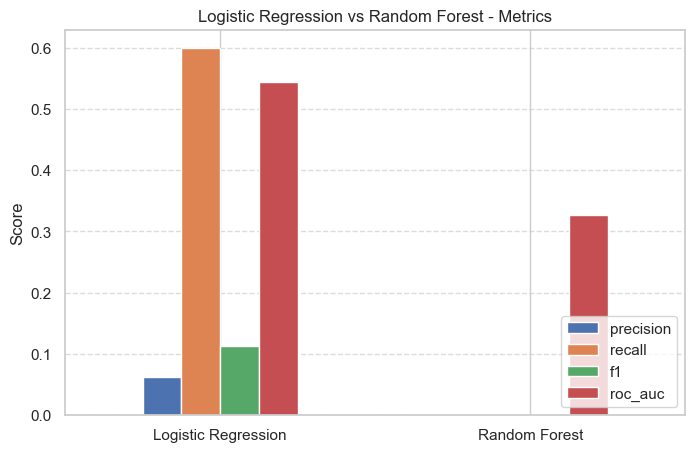

In [37]:
# ============================
# Compare Logistic Regression vs Random Forest
# ============================

import matplotlib.pyplot as plt

# 1) Collect metrics into a dict
results = {
    "Logistic Regression": {
        "precision": precision_score(y_test, lr.predict(X_test), zero_division=0),
        "recall": recall_score(y_test, lr.predict(X_test), zero_division=0),
        "f1": f1_score(y_test, lr.predict(X_test), zero_division=0),
        "roc_auc": roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]),
    },
    "Random Forest": {
        "precision": precision_score(y_test, rf.predict(X_test), zero_division=0),
        "recall": recall_score(y_test, rf.predict(X_test), zero_division=0),
        "f1": f1_score(y_test, rf.predict(X_test), zero_division=0),
        "roc_auc": roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]),
    }
}

# 2) Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

# 3) Bar chart for visual comparison
results_df.plot(kind='bar', figsize=(8,5))
plt.title("Logistic Regression vs Random Forest - Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
